In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import datetime as dt

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  warn("IPython.utils.traitlets has moved to a top-level traitlets package.")
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated since IPython 4.0.You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import pylab
sns.set(font_scale=2)
pylab.rcParams['figure.figsize'] = (24, 18)

In [3]:
def xirr(transactions):
    years = [(ta[0] - transactions[-1][0]).days / 365.25 for ta in transactions]
    residual = 1
    step = 0.05
    guess = 0.08
    epsilon = 0.0001
    limit = 100000
    while abs(residual) > epsilon and limit > 0:
        limit -= 1
        residual = 0.0
        for i, ta in enumerate(transactions):
            residual += ta[1] / pow(guess, years[i])
        if abs(residual) > epsilon:
            if residual > 0:
                guess += step
            else:
                guess -= step
                step /= 2.0
    return guess-1

In [4]:
x=pd.read_csv('IRR_data.csv',index_col=3,parse_dates=['Transaction Date'])
sp=pd.read_csv('SP500.csv',parse_dates=['DATE'],index_col=0,na_values='.')

In [5]:
df=pd.read_csv('IRR_data.csv',parse_dates=['Transaction Date'],na_values='.')
df=pd.pivot_table(df,columns='Security Description',index='Transaction Date')
df['SP']=sp.SP500


# Calculate IRR 

In [6]:
funds={}
funds_wo_fee={}
sp_rtn=pd.Series()
year=pd.Series()
for r in x.iterrows():
    if r[0] not in funds.keys():
        funds[r[0]]=[]
        funds_wo_fee[r[0]]=[]
        year[r[0]]=r[1]['Transaction Date'].date().year
        ann_years=(dt.datetime.today().date()-r[1]['Transaction Date'].date()).days/365.
        sp_rtn[r[0]]=(sp.ix[-1].SP500/df.SP.ffill()[r[1]['Transaction Date']])**(1/ann_years)-1
    try:
        funds[r[0]].append([r[1]['Transaction Date'].date(),float(r[1]['Reporting Amount'])])
        if r[1]['Type']!='Fees paid - Asset account':
            funds_wo_fee[r[0]].append([r[1]['Transaction Date'].date(),float(r[1]['Reporting Amount'])])
    except:
        continue
    

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [7]:
rtn=pd.Series()
rtn_wo=pd.Series()
results=pd.DataFrame()
for f in funds.keys():
    val=round(xirr(funds[f])*100.,2)
    val_wo=round(xirr(funds_wo_fee[f])*100.,2) 
    if val>100:
        continue
    rtn[f]=val
    rtn_wo[f]=val_wo
results['IRR']=rtn
results['IRR without fees']=rtn_wo
results['Vintage']=year
results['SP Annualized Return since Inception']=(sp_rtn*100.).round(2)
results=results.sort_values('IRR')

In [8]:
results

,IRR,IRR without fees,Vintage,SP Annualized Return since Inception
Coachman Energy VII Offshore Feeder Bn,-34.55,-34.08,2015,9.31
HH Pre-IPO Offshr Feeder Fd II LP S B Bn,-10.12,-2.83,2017,13.58
Eur Special Sits Offshr Feeder Fd LP Bn,-3.15,-0.89,2016,16.91
European Primary Lending Opp Offshore Bn,1.91,2.54,2014,9.12
"W ST DF Onshore Feeder Fund, L.P. B",2.69,5.50,2016,14.71
C VIII Real Estate Opp Onshore A,3.07,4.84,2017,14.35
G Rockies Offshore Feeder Fund Ltd Bn,3.95,4.90,2015,12.22
"BTO II Offshore Feeder Fund, Ltd. Bn",4.72,7.39,2015,13.90
"CTP Offshore Feeder Fund, L.P. Bn",5.64,6.57,2014,9.65
Wellington HH Pr-IPO Ofshr Feeder Fd Bn,6.46,7.55,2015,9.35


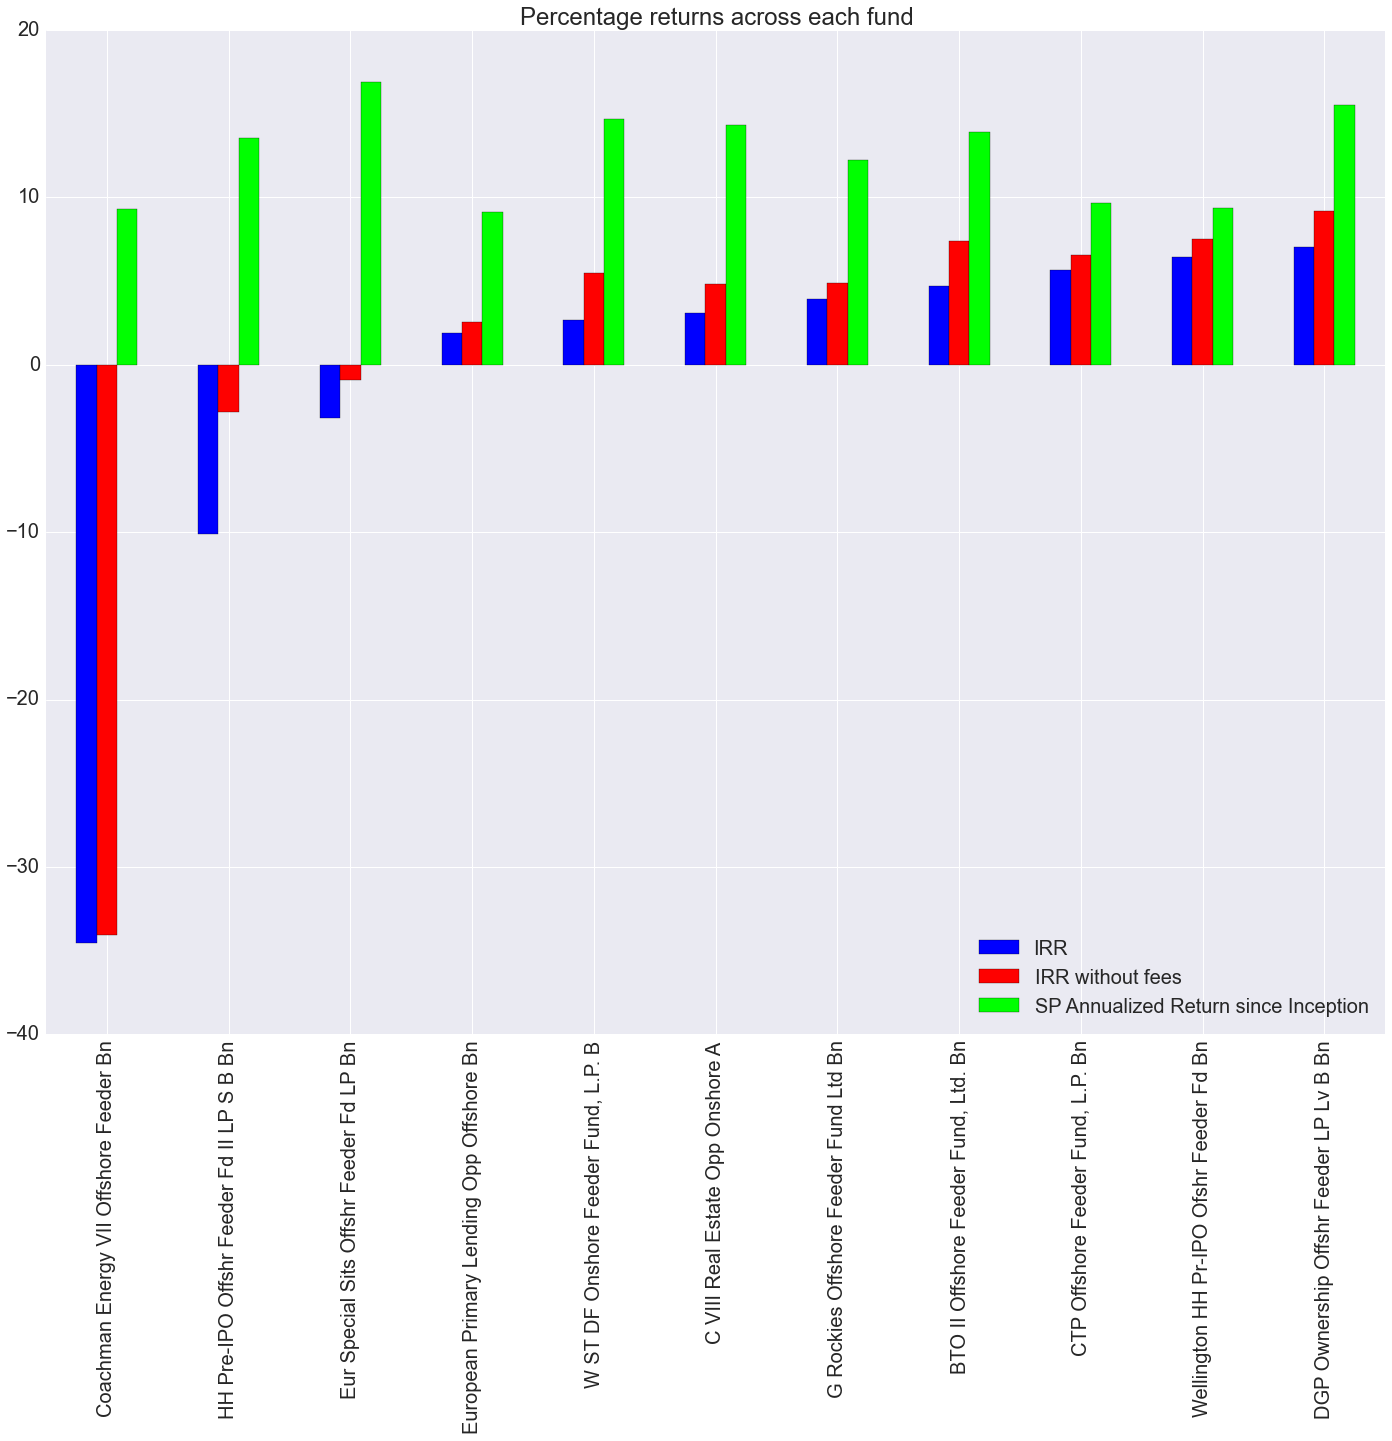

In [9]:
results[['IRR','IRR without fees','SP Annualized Return since Inception']].plot(kind='bar',colormap='brg', title='Percentage returns across each fund')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/seaborn/categorical.py:1468: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


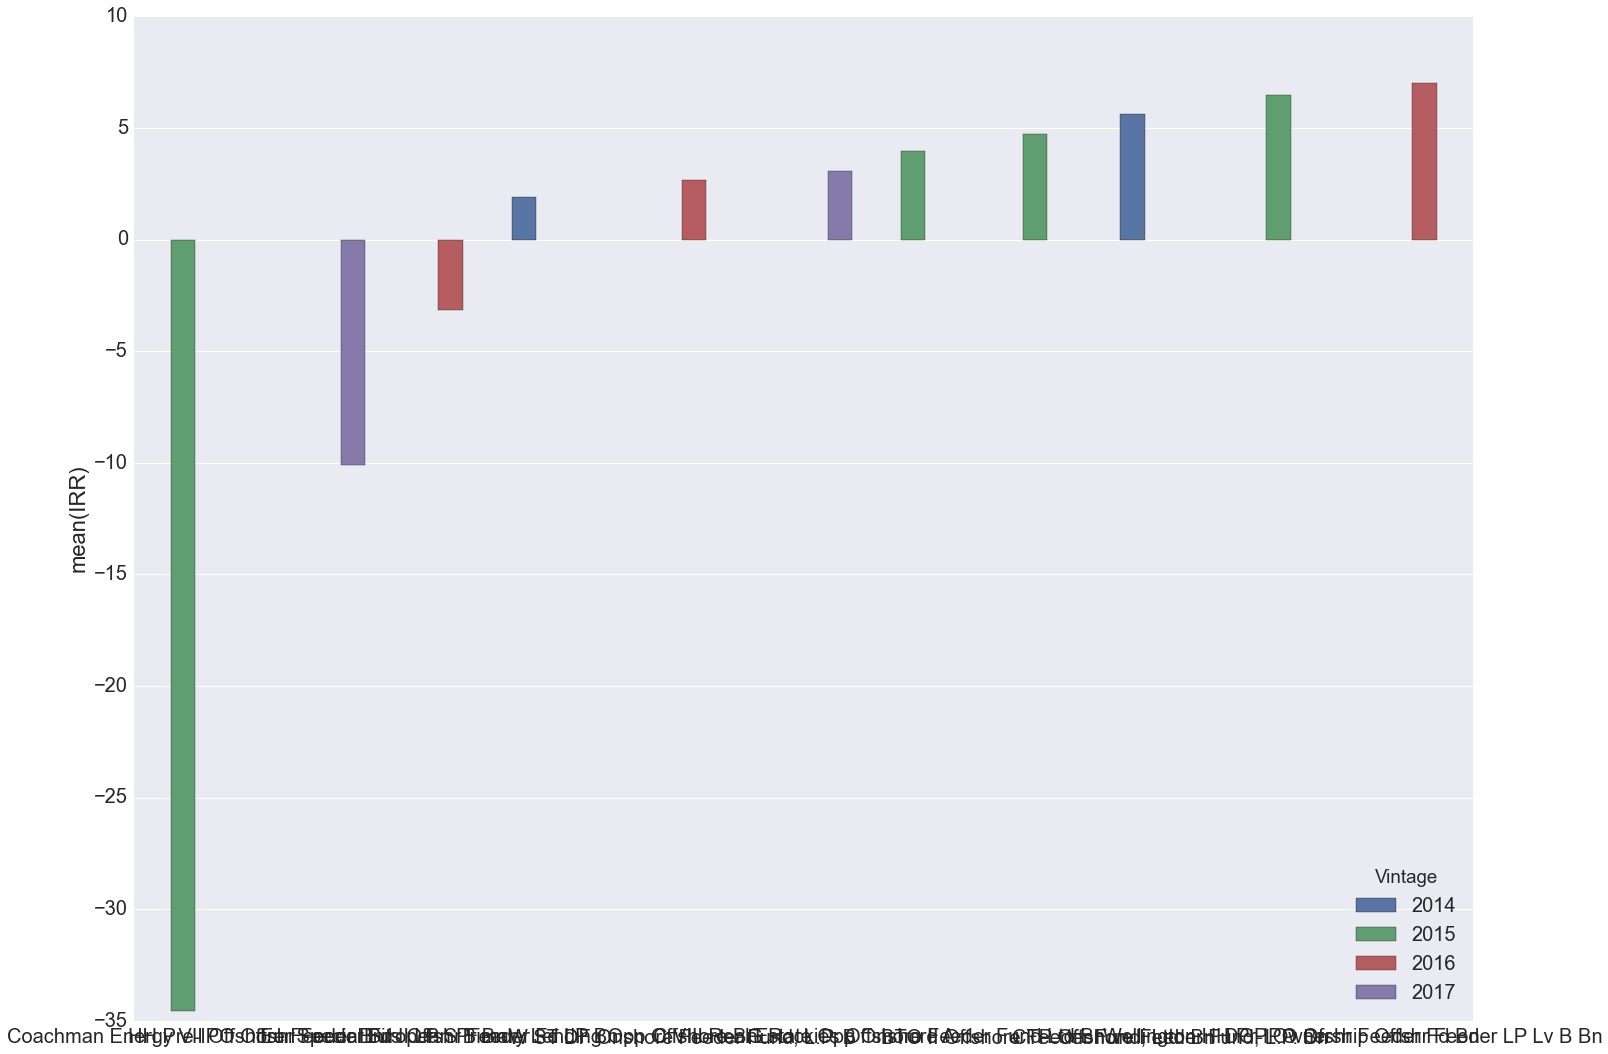

In [10]:
sns.barplot(results.index,results.IRR,hue=results.Vintage,orient=0)

# Time series of Capital

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


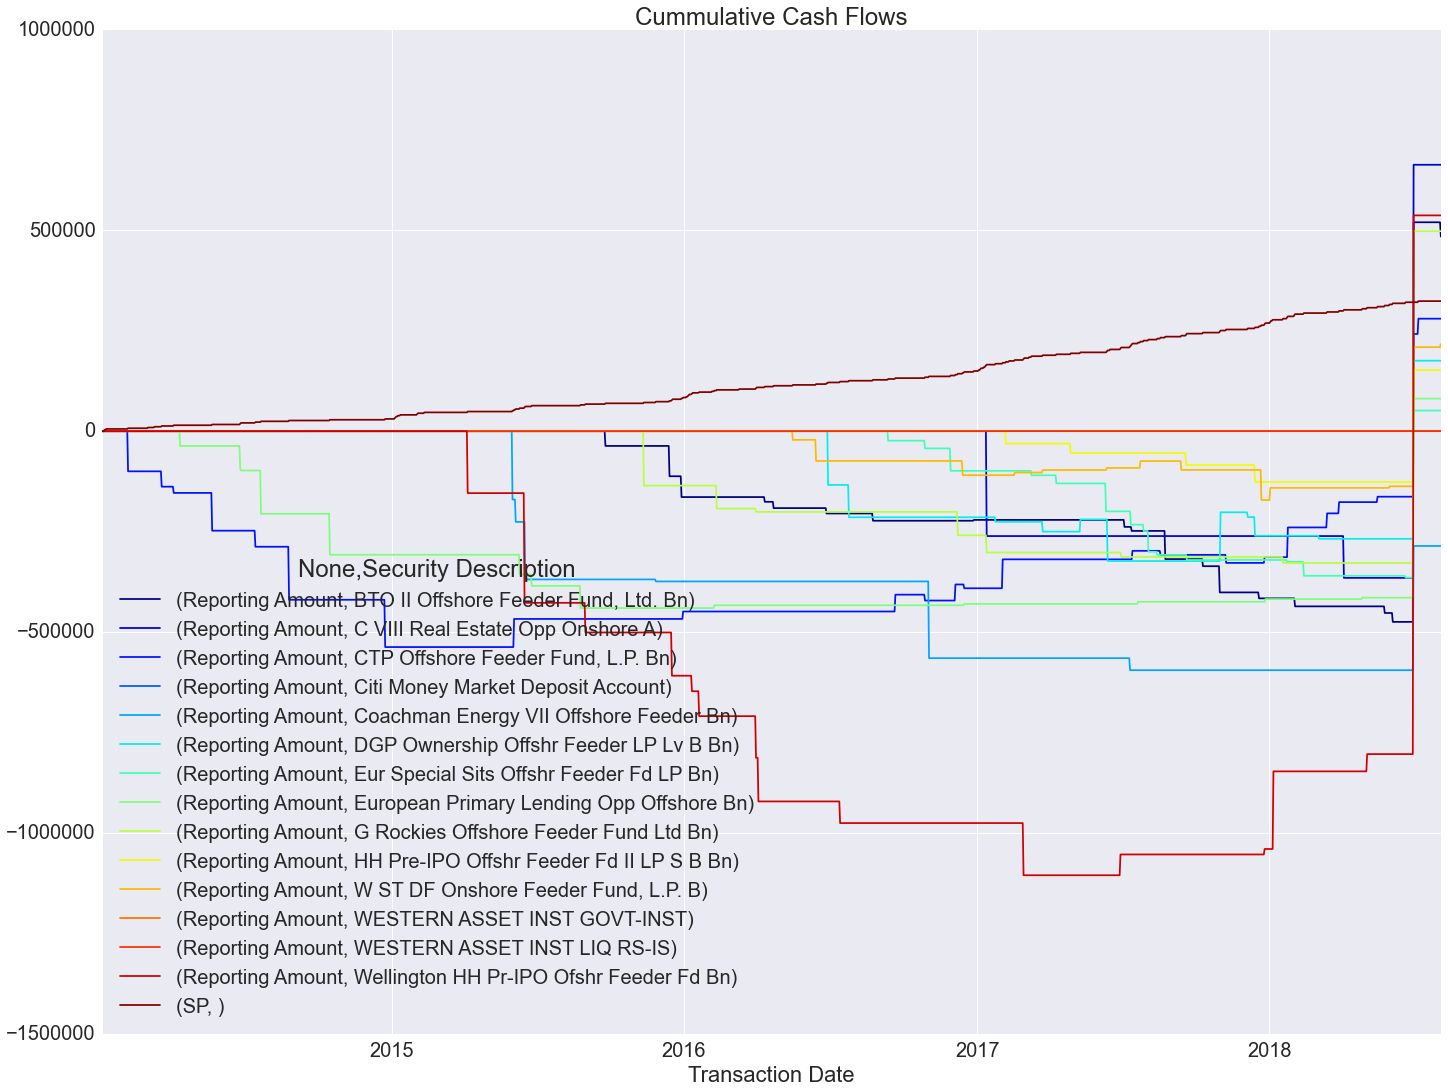

In [11]:
df.resample(rule='d',how='sum').cumsum().plot(colormap='jet',title='Cummulative Cash Flows')

In [12]:
df.resample(rule='d',how='sum').cumsum().max()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  """Entry point for launching an IPython kernel.


                  Security Description                    
Reporting Amount  BTO II Offshore Feeder Fund, Ltd. Bn        519930.110000
                  C VIII Real Estate Opp Onshore A            663054.105000
                  CTP Offshore Feeder Fund, L.P. Bn           279960.960000
                  Citi Money Market Deposit Account               22.500000
                  Coachman Energy VII Offshore Feeder Bn           0.000000
                  DGP Ownership Offshr Feeder LP Lv B Bn      175390.135000
                  Eur Special Sits Offshr Feeder Fd LP Bn      51344.716667
                  European Primary Lending Opp Offshore Bn     81036.490000
                  G Rockies Offshore Feeder Fund Ltd Bn       497786.866667
                  HH Pre-IPO Offshr Feeder Fd II LP S B Bn    152057.519167
                  W ST DF Onshore Feeder Fund, L.P. B         216716.939167
                  WESTERN ASSET INST GOVT-INST                   589.292500
                  WESTERN ASS

# Return Multiples 

In [13]:
flows={}
for f in funds.keys():
    inflow=0
    outflow=0
    for r in funds[f]:
        if r[1]>0:
            inflow=inflow+r[1]
        else:
            outflow=outflow+r[1]
    flows[f]=[inflow,outflow*-1.]

In [14]:
a=pd.DataFrame(flows,index=['Inflow','Outflow']).T

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


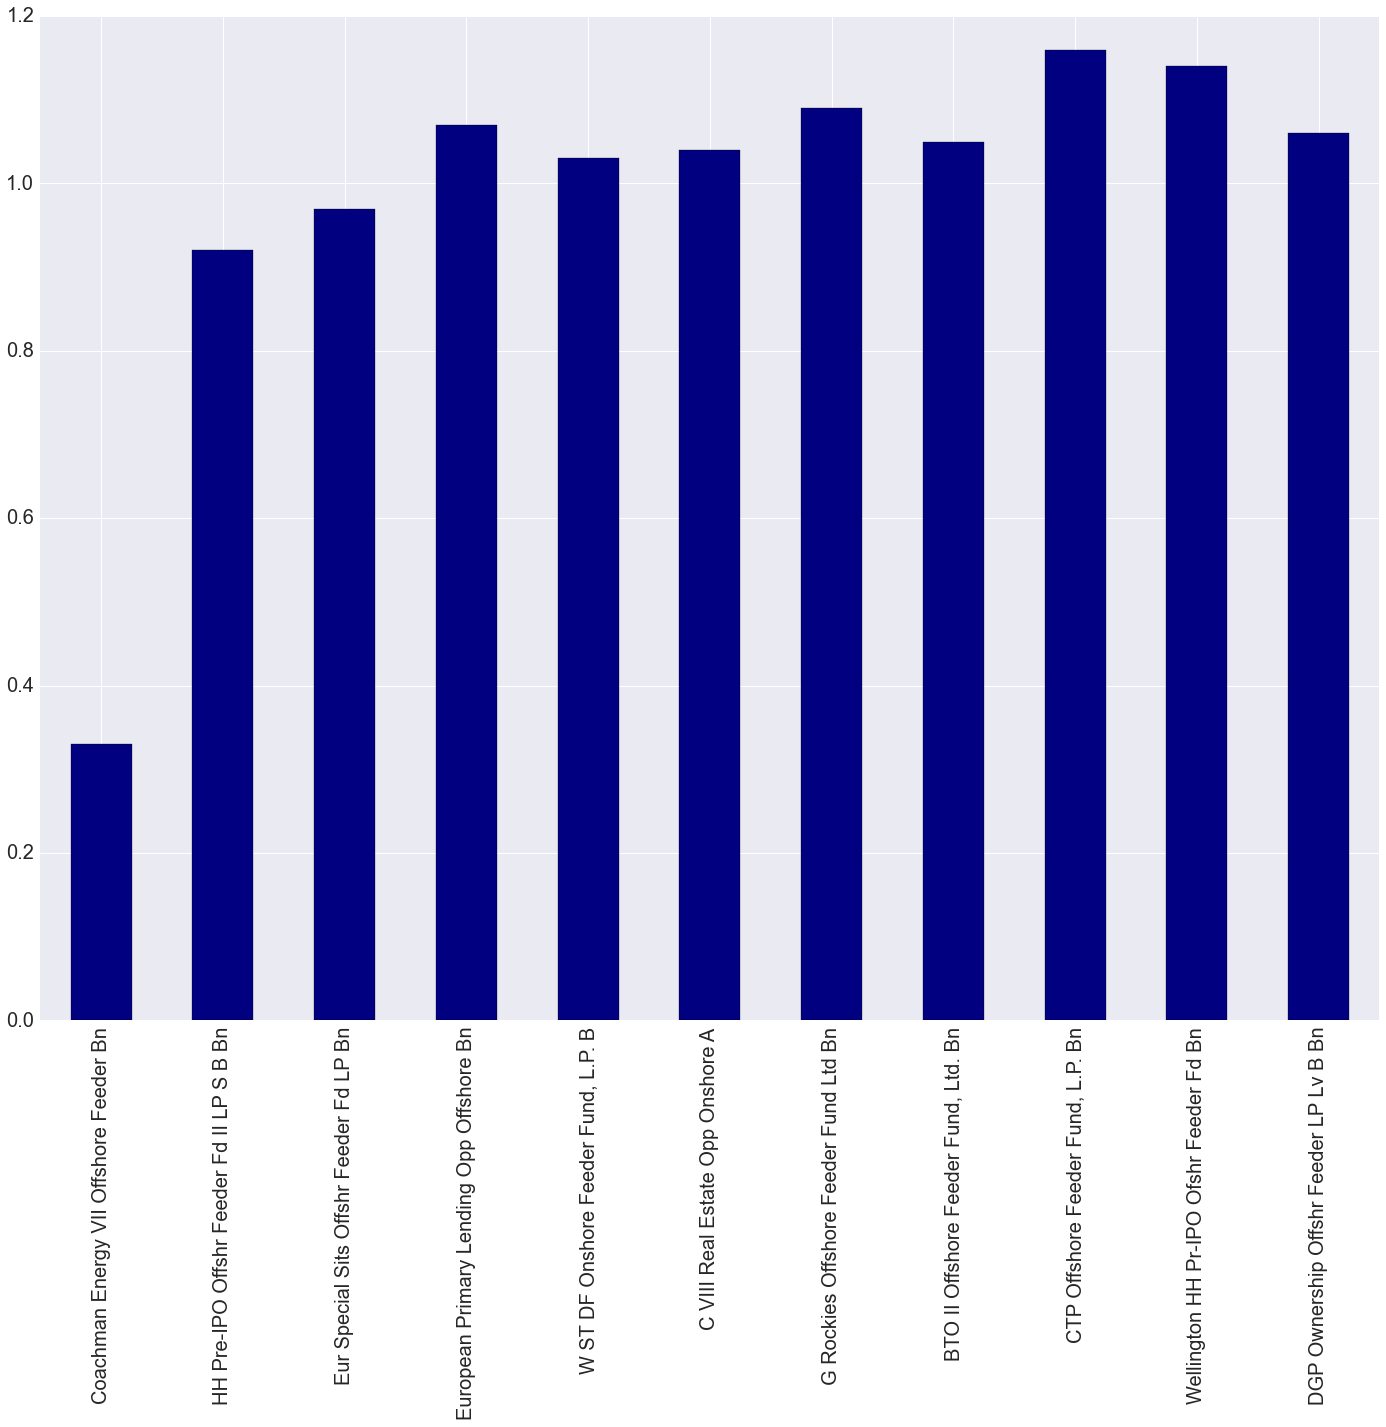

In [15]:
(a.Inflow/a.Outflow).round(2).ix[results.index].plot(kind='bar',colormap='jet')

In [16]:
final_res=results[[u'IRR', u'IRR without fees',
       u'SP Annualized Return since Inception']]
final_res['Multiples']=(a.Inflow/a.Outflow).round(2).ix[results.index]

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  This is separate from the ipykernel package so we can avoid doing imports until


array([<matplotlib.axes._subplots.AxesSubplot object at 0x10cc4c910>], dtype=object)

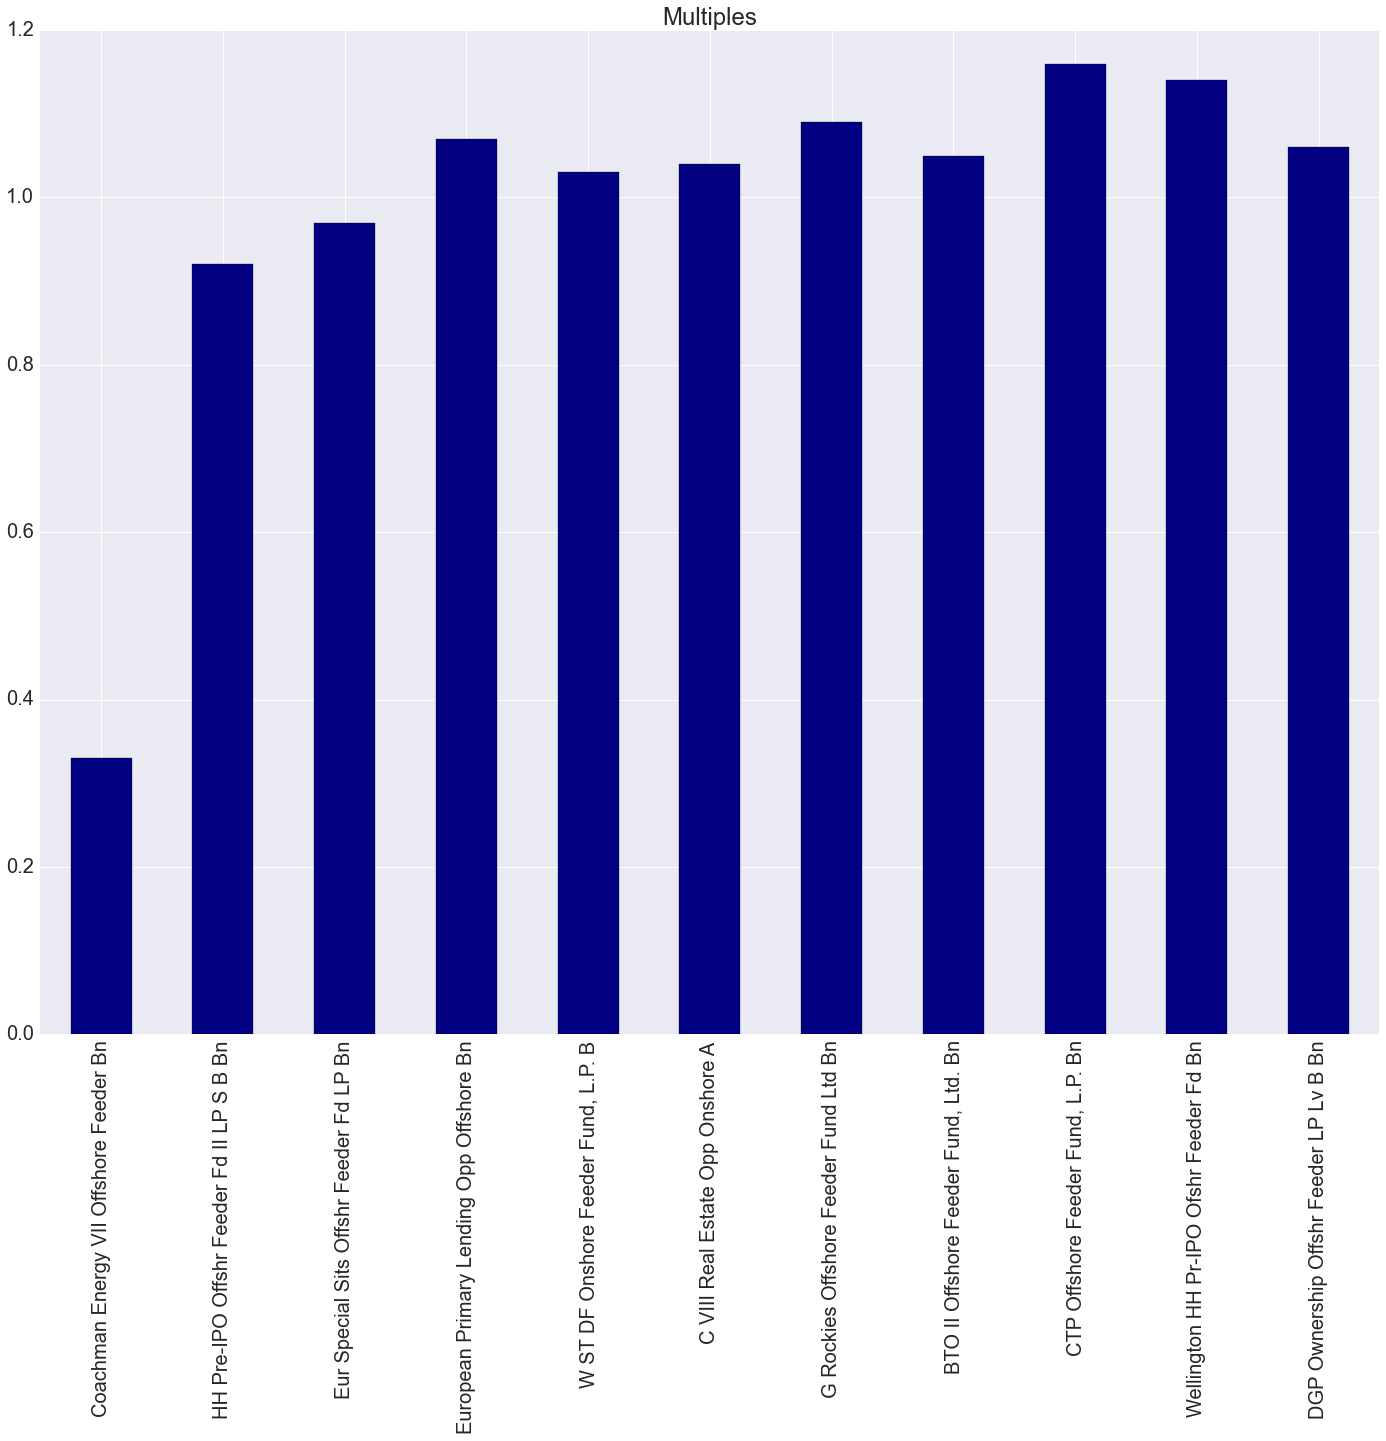

In [17]:
final_res.Multiples.plot(kind='bar',subplots=True,colormap='jet')

# March 2018 Valuation

In [18]:
data=pd.read_csv('IRR_data_March18.csv',index_col=3,parse_dates=['Transaction Date'])

In [19]:
funds={}
funds_wo_fee={}
sp_rtn=pd.Series()
year=pd.Series()
for r in data.iterrows():
    if r[0] not in funds.keys():
        funds[r[0]]=[]
        funds_wo_fee[r[0]]=[]
        year[r[0]]=r[1]['Transaction Date'].date()
        ann_years=(dt.datetime.today().date()-r[1]['Transaction Date'].date()).days/365.
        sp_rtn[r[0]]=(sp.resample(rule='q',how='last').ix[-3].SP500/df.SP.ffill()[r[1]['Transaction Date']])**(1/ann_years)-1
    try:
        funds[r[0]].append([r[1]['Transaction Date'].date(),float(r[1]['Reporting Amount'])])
        if r[1]['Type']!='Fees paid - Asset account':
            funds_wo_fee[r[0]].append([r[1]['Transaction Date'].date(),float(r[1]['Reporting Amount'])])
    except:
        print r
        continue
    

/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  # This is added back by InteractiveShellApp.init_path()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  # This is added back by InteractiveShellApp.init_path()


In [20]:
rtn=pd.Series()
rtn_wo=pd.Series()
results_march=pd.DataFrame()
for f in funds.keys():
    val=round(xirr(funds[f])*100.,2)
    val_wo=round(xirr(funds_wo_fee[f])*100.,2) 
    if val>100:
        continue
    rtn[f]=val
    rtn_wo[f]=val_wo
results_march['IRR']=rtn/100.
results_march['IRR without fees']=rtn_wo/100.
results_march['Vintage']=year
results_march['SP Annualized Return since Inception']=(sp_rtn).round(4)
results_march=results_march.sort_values('IRR')

In [21]:
actual=pd.Series({'W ST DF Onshore Feeder Fund, L.P. B':0,
 'C VIII Real Estate Opp Onshore A':0.0654,
 'Coachman Energy VII Offshore Feeder Bn':0,
 'CTP Offshore Feeder Fund, L.P. Bn':0.0714,
 'Wellington HH Pr-IPO Ofshr Feeder Fd Bn':0.0989,
 'DGP Ownership Offshr Feeder LP Lv B Bn':0,
 'European Primary Lending Opp Offshore Bn':0,
 'Eur Special Sits Offshr Feeder Fd LP Bn':-0.0501,
 'HH Pre-IPO Offshr Feeder Fd II LP S B Bn':0,
 'G Rockies Offshore Feeder Fund Ltd Bn':0.0933,
 'BTO II Offshore Feeder Fund, Ltd. Bn':0})

In [22]:
results_march['Actual']=actual

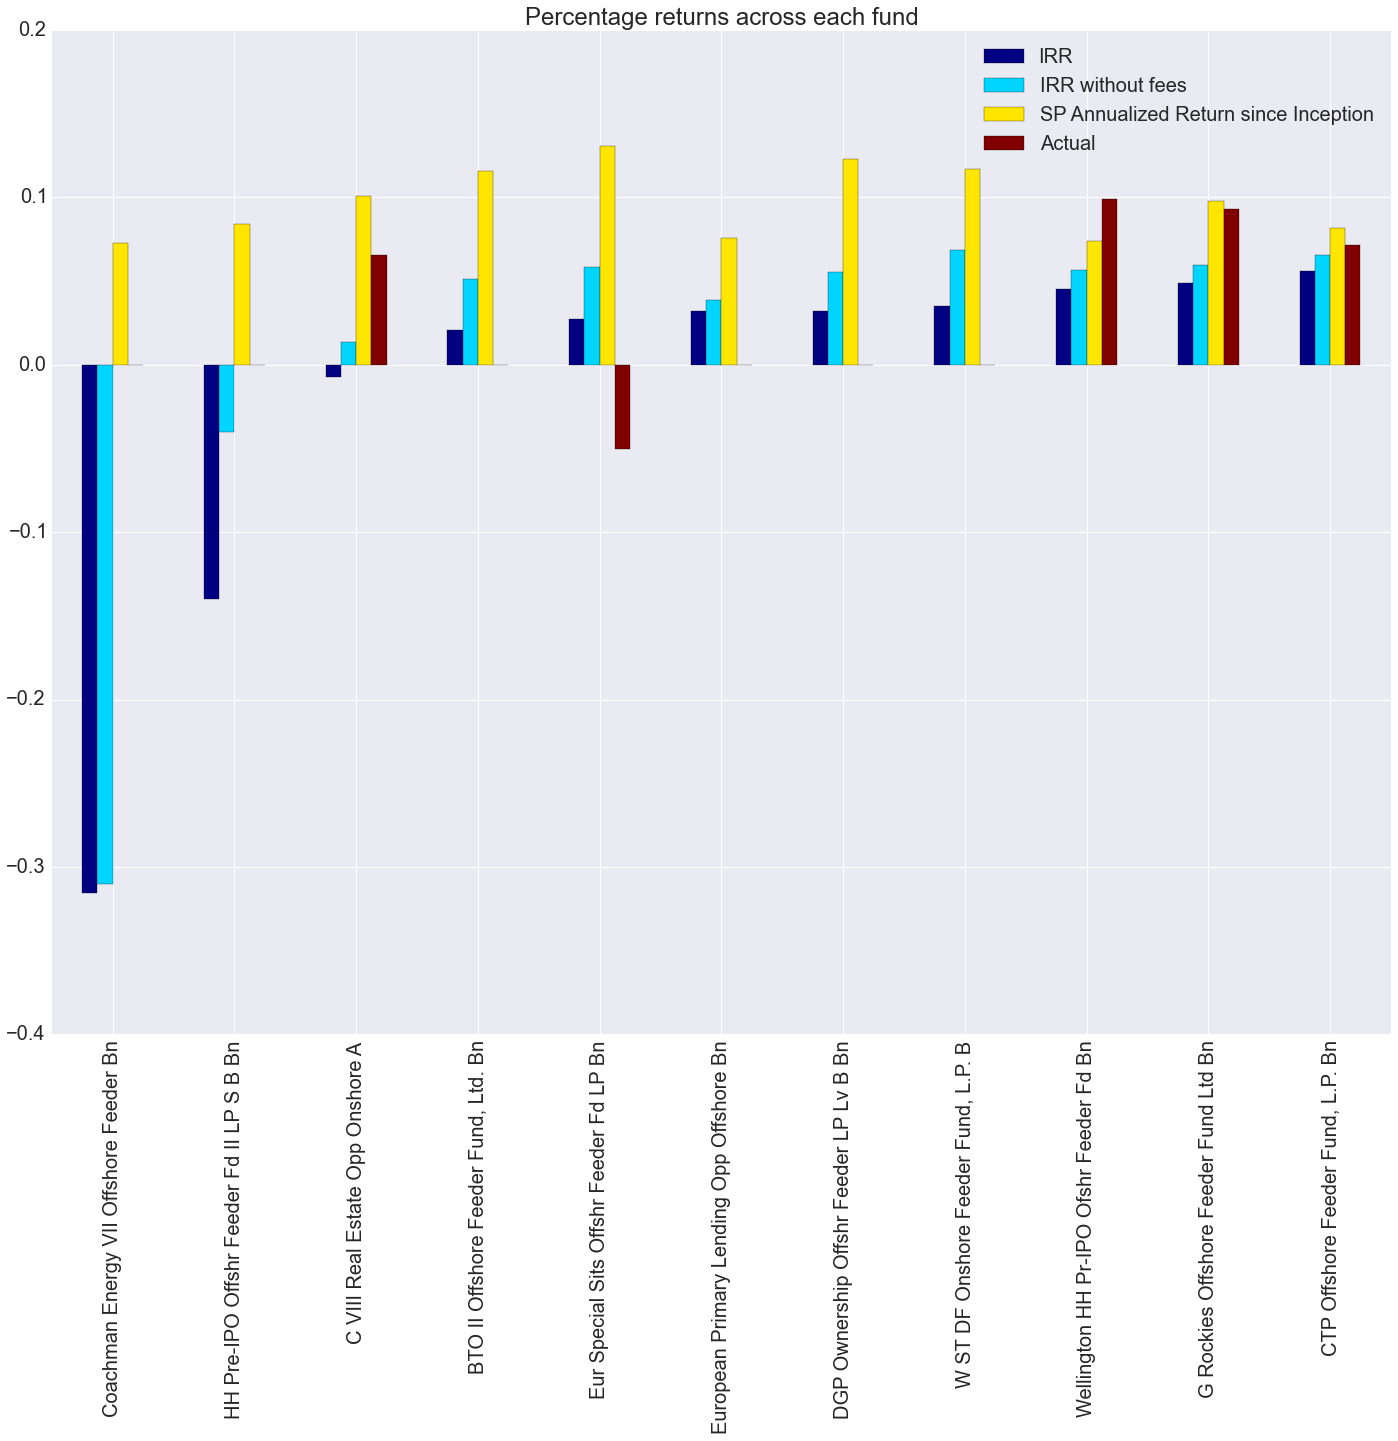

In [23]:
results_march[['IRR','IRR without fees','SP Annualized Return since Inception','Actual']].plot(kind='bar',colormap='jet', title='Percentage returns across each fund')

In [24]:
results_march[['IRR','IRR without fees','SP Annualized Return since Inception','Actual']]

,IRR,IRR without fees,SP Annualized Return since Inception,Actual
Coachman Energy VII Offshore Feeder Bn,-0.3155,-0.3100,0.0730,0.0000
HH Pre-IPO Offshr Feeder Fd II LP S B Bn,-0.1398,-0.0399,0.0841,0.0000
C VIII Real Estate Opp Onshore A,-0.0075,0.0139,0.1009,0.0654
"BTO II Offshore Feeder Fund, Ltd. Bn",0.0208,0.0516,0.1157,0.0000
Eur Special Sits Offshr Feeder Fd LP Bn,0.0273,0.0587,0.1307,-0.0501
European Primary Lending Opp Offshore Bn,0.0320,0.0389,0.0757,0.0000
DGP Ownership Offshr Feeder LP Lv B Bn,0.0321,0.0555,0.1230,0.0000
"W ST DF Onshore Feeder Fund, L.P. B",0.0351,0.0684,0.1170,0.0000
Wellington HH Pr-IPO Ofshr Feeder Fd Bn,0.0456,0.0568,0.0743,0.0989
G Rockies Offshore Feeder Fund Ltd Bn,0.0489,0.0597,0.0982,0.0933
